# Задача 12 (бонус). Экспериментальное исследование алгоритмов решения задачи достижимости с КС ограничениями

## Введение

В данной работе рассматривается задача достижимости в графе с контекстно-свободными ограничениями: исследуется производительность нескольких алгоритмов её решения, основанных на линейной алгебре, а также проводится их сравнение с решением схожей задачи при регулярных ограничениях. Алгоритмы реализованы на языке Python так, что матричные операции осуществляются на CUDA-ядрах GPU при помощи библиотеки [pyCuBool](https://pypi.org/project/pycubool/).


### Описание задачи достижимости
Пусть имеется размеченный граф $G(V, E, Lab)$. Тогда конечный автомат построенный по этому графу (рёбра → переходы, вершины → состояния) допускает регулярный язык $L_G$

Пусть нам задана КС-грамматика $CFG$, задающая язык ограничений $L_{CFG}$.

Тогда задача достижимости заключается в нахождение следующего множества: $CFPQ = \{(v_i, v_j)|\exists\pi:w(v_i\pi v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_{CFG}$, $V_S \in V$ --- множество стартовых вершин и $V_F \in V$ --- множество финальных вершин

### Исследуемые решения

Рассматриваются следующие алгоритмы решения задачи достижимости с контекстно-свободными ограничениями. В каждом алгоритме строится транзитивное замыкание графа с учётом правил ограничивающей грамматики:

1. Алгоритм Хеллингса. Грамматика переводится в ОНФХ. Поддерживается множество рёбер графа, которые ещё не были рассмотрены. Рассмотрение очередного ребра заключается в проверке его в паре с каждым смежным с ним ребром на порождаемость в грамматике. В случае, если пара порождаема, то на рассмотрение добавляется соответствующее ребро с порождающим символом. 

2. Матричный алгоритм. Грамматика переводится в ОНФХ. Затем строится матрица смежности графа, по которой вычисляется транзитивное замыкание --- пока матрица меняется проводится аккумулирование результата возведения её в квадрат.

3. Тензорный алгоритм. По грамматике строится рекурсивный автомат. Для графа и полученного автомата строятся матрицы смежности. Затем, пока транзитивное замыкание не построено (пока в нём добавляются новые рёбра), строится пересечение матриц и его транзитивное замыкание, новые рёбра которого добавляются в графи его матрицу смежности.

Также для сравнения с вышеприведёнными алгоритмами используется алгоритм решения задачи $RPQ$ между всеми парами вершин, так как в [предыдущей работе](https://colab.research.google.com/drive/1Gau-VhZ0J6JO7-60HCzNHnrSo1N51MS_?usp=sharing) согласно экспериментам было получено, что лучше других подходит данной постановке задачи. 
Дополнительно стоит отметить, что алгоритм Хеллингса не использует матричные операции и его реализация не использует технологию $GPGPU$

### Цель работы

Целью данной работы является сравнение решений задачи достижимости с ограничениями в терминах формальных языков, а именно, нахождение ответов на следующие вопросы:

1. Какой из трёх указанных алгоритмов решения задачи с контекстно-свободными ограничениями (Хеллингса, матричный или тензорный) обладает лучшей производительностью?
2. Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для контекстно-свободных ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?


## Описание экспериментов

### Подготовка окружения

In [1]:
# Установка проекта 
!git clone -b task_12_expirement https://github.com/Nikita-Fast/formal-lang-course.git

Cloning into 'formal-lang-course'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 932 (delta 52), reused 94 (delta 49), pack-reused 829
Receiving objects: 100% (932/932), 2.55 MiB | 2.56 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [2]:
%%capture
# Установка зависимостей проекта
!pip install -r formal-lang-course/requirements.txt
# Установка библиотеки pycubool
!pip install pycubool

# Установка библиотек для красивых графиков
!pip install matplotlib
!pip install seaborn

!pip install -Uqq ipdb

In [3]:
# Подключение директории проекта
import sys
sys.path.insert(1, "formal-lang-course")

### Характеристики оборудования

In [4]:
# Сведения об операционной системе
!cat /etc/os-release

NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


In [5]:
# Сведения об используемом CPU
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Socket(s):                       1
Core(s) per socket:              1
Thread(s) per core:              2
CPU MHz:                         2000.146


In [6]:
# Сведения об используемом GPU
!nvidia-smi

Wed Mar 22 07:58:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Сведения о размере оперативной памяти системы в GB
!echo 'Total RAM (GB)'
!awk '( $1 == "MemTotal:" ) { print $2/1048576 }' /proc/meminfo

Total RAM (GB)
12.6812


### Описание данных для экспериментов

В качестве графов для экспериментов будем использовать графы из [cfpq-data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html) датасета. Были выбраны следующие графы из различных категорий:

* RDF-графы: [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go.html#go), [atom](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/atom.html#atom), [go_hierarchy](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go_hierarchy.html#go-hierarchy), [go](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go.html#go)
* Графы языка Си: [bzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go.html#go), [ls](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/ls.html#ls), [apache](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/apache.html#apache)
* Графы языка Java: [lusearch](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/lusearch.html#lusearch), [sunflow](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/sunflow.html#sunflow), [pmd](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/pmd.html#pmd), [jython](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/jython.html#jython)

Использовать для замеров графы, обладающие большим числом вершин, на представленном оборудовании оказалось невозможно из-за нехватки видеопамяти для алгоритмов, использующих GPU. Выбранные графы были взяты разных размеров, от маленьких на несколько сотен вершин, до графов с несколькими миллионами вершин, в том числе с несколькими компонентами связности.

In [8]:
GRAPH_NAMES = [
    # Маленькие графы
    "skos",
    "bzip",
    "atom",
    "ls",
    
    # Средние графы
    "lusearch",
    "sunflow",
    "pmd",
    "jython",

    # Большие графы
    "go",
    "apache"
]
SMALL_GRAPHS = {
    # Маленькие графы
    "skos",
    "bzip",
    "ls",
    "atom"
}
MEDIUM_GRAPHS = {
    # Средние графы
    "pmd",
    "lusearch",
    "sunflow",
    "jython",
}
LARGE_GRAPHS = {
    # Большие графы
    "go",
    "apache"
}
GRAPHS_RDF = [
    "skos", 
    "atom", 
    "go"
]
GRAPHS_C = [
    "bzip", 
    "ls",
    "apache" 
]
GRAPHS_JAVA = [
    "pmd",
    "lusearch", 
    "sunflow", 
    "jython",
]

In [9]:
## Для получения информации о графах необходимо раскомментировать эту ячейку и запустить

# Информация о графах

from project.graph_tools import get_graph_info
import pandas as pd 
import cfpq_data

edges = []
nodes = []

for graph_name in GRAPH_NAMES:
    graph_info = get_graph_info(graph_name)
    edges.append(graph_info[1])
    nodes.append(graph_info[0])


df = pd.DataFrame(
    {
        "Edges": edges,
        "Nodes": nodes,
    },
    index=GRAPH_NAMES
)
df

import sources directory


,Edges,Nodes
skos,252,144
bzip,556,632
atom,425,291
ls,1453,1687
lusearch,14994,15774
sunflow,15957,15464
pmd,59329,54444
jython,260034,191895
go,1437437,582929
apache,1510411,1721418


### Запросы

Для каждой группы графов были выбраны свои контекстно-свободные запросы:

* Для RDF-графов: 
    1. `S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type`
    2. `S -> subClassOf_r S subClassOf | subClassOf_r subClassOf`
    3. `S -> type_r S type | type_r type` 
* Для графов языка C:
```
S -> d_r V d
V -> V1 V2 V3
V1 -> epsilon
V1 -> V2 a_r V1
V2 -> epsilon
V2 -> S
V3 -> epsilon
V3 -> a V2 V3
```
* Для графов языка Java:
```
S -> PTh alloc
PTh -> epsilon
PTh -> assign PTh
(for each field f) PTh -> load_f Al store_f PTh
FT -> alloc_r FTh
FTh -> epsilon
FTh -> assign_r FTh
(for each field f) FTh -> store_f_r Al load_f_r FTh
Al -> S FT
```

Регулярные запросы были взяты из [предыдущей работы](https://colab.research.google.com/drive/1g9P3BMoqR9ok1uu4vSGiNGzE6DrG-Y-Z?authuser=1#scrollTo=rdDkTi4vSzdp&uniqifier=5) (если в графе число меток меньше числа запросов, тогда метки дополняются уже имеющимися. В графе должна быть по крайней мере 1 метка, иначе эксперимент не имеет смысла):
- $(L_0 | L_1 | L_2)^* \: L_3$
- $(L_0 | L_2)$+ ${L_1}^*$
- $L_0\,L_1\,L_2\,(L_3 | L_1)^*$
- $(L_0 | L_3)^*\,\,|\,\,(L_1 | L_2)^*$
- $(L_0 L_1 L_2)^* | L_3$

Для алгоритмов решения задачи $CFPQ$ регулярные запросы переводились в КС грамматики.

In [10]:

# Генерация регулярных выражений

from pyformlang.regular_expression.regex_objects import Symbol
from pyformlang.regular_expression import Regex

NUMBER_OF_LABELS = 4

def regex_from_label(label):
    regex = Regex("")
    regex.head = Symbol(str(label))
    return regex

def expand(lst, expand_size):
    """
    If number of labels < NUMBER_OF_LABELS, then expand them with existing ones
    """
    expand_length = expand_size - len(lst)
    if expand_length <= 0:
        return lst
    expanded_lst = lst.copy()
    for i in range(expand_length):
        expanded_lst.append(expanded_lst[i])
    return expanded_lst

def regex_first(labels):
    """
    (l0 | l1 | l2)* l3
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.union(regex_1).union(regex_2).kleene_star().concatenate(regex_3)
  

def regex_second(labels):
    """
    (l0 | l2)+ l1*
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    return regex_0.union(regex_2).union(regex_1.kleene_star())

def regex_third(labels):
    """
    l0 l1 l2 (l3 | l1)*
    """ 
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.concatenate(regex_1).concatenate(regex_2).concatenate((regex_3.union(regex_1)).kleene_star())

def regex_fourth(labels):
    """
    (l0 | l3)* | (l1 | l2)*
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    left_regex = (regex_0.union(regex_3)).kleene_star()
    right_regex = (regex_1.union(regex_2)).kleene_star()
    return left_regex.union(right_regex)

def regex_fifth(labels):
    """
    (l0 l1 l2)* | l3
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.concatenate(regex_1).concatenate(regex_2).kleene_star().union(regex_3)

def reg_to_cfg(r):
    return lambda labs: r(labs).to_cfg()

CFG_GENERATORS = ((regex_first.__doc__.strip().strip('\n'), reg_to_cfg(regex_first)), 
                  (regex_second.__doc__.strip().strip('\n'), reg_to_cfg(regex_second)), 
                  (regex_third.__doc__.strip().strip('\n'), reg_to_cfg(regex_third)), 
                  (regex_fourth.__doc__.strip().strip('\n'), reg_to_cfg(regex_fourth)), 
                  (regex_fifth.__doc__.strip().strip('\n'), reg_to_cfg(regex_fifth))
                 )

REG_GENERATORS = ((regex_first.__doc__.strip().strip('\n'), regex_first), 
                  (regex_second.__doc__.strip().strip('\n'), regex_second), 
                  (regex_third.__doc__.strip().strip('\n'), regex_third), 
                  (regex_fourth.__doc__.strip().strip('\n'), regex_fourth), 
                  (regex_fifth.__doc__.strip().strip('\n'), regex_fifth)
                 )

In [11]:
import pyformlang.cfg as c
import cfpq_data


def get_cf_queries(graph):
    if graph in GRAPHS_RDF:
        return list(CFG_RDF.items())
    elif graph in GRAPHS_C:
        return list(CFGS_C.items())
    elif graph in GRAPHS_JAVA:
        return list(CFGS_JAVA.items())
    else:
        raise ValueError("Unknown graph")


CFG_RDF = {
    "rdf_1": c.CFG.from_text(
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type"
    ),
    "rdf_2": c.CFG.from_text("S -> subClassOf_r S subClassOf | subClassOf_r subClassOf"),
    "rdf_3": c.CFG.from_text("S -> type_r S type | type_r type"),
}

CFGS_C = {
    "c_alias": c.CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
}

CFGS_JAVA = {
    "java_points_to": c.CFG.from_text(
        """
        S -> PTh alloc
        PTh -> epsilon
        PTh -> assign PTh
        PTh -> load_0 Al store_0 PTh
        PTh -> load_1 Al store_1 PTh
        FT -> alloc_r FTh
        FTh -> epsilon
        FTh -> assign_r FTh
        FTh -> store_0_r Al load_0_r FTh
        FTh -> store_1_r Al load_1_r FTh
        Al -> S FT
        """
    )
}

### Определение нужных замеров

Для ответа на первый вопрос (о сравнении производительности КС-алгоритмов) необходимо замерить время работы каждого КС-алгоритма на каждом графе и КС-запросе.  Алгоритм, затрачивающий наименьшее число времени для решения задачи, будет обладать наибольшей производительностью.

Для ответа на второй вопрос (о выгоде от использования специальных алгоритмов для регулярных запросов) необходимо замерить время работы каждого КС-алгоритма и наиболее быстрого из алгоритмов для регулярных запросов (выбранного по результату предыдущей работы) на каждом графе и каждом регулярном запросе. В случае, если регулярный алгоритм окажется быстрее всех КС-алгоритмов, использовать его для регулярных запросов будет эффективнее.

Итого, для каждого графа и каждого КС-запроса нужно провести замеры времени работы КС-алгоритмов, а также для каждого графа и каждого регулярного запроса нужно провести замеры времени работы КС-алгоритмов и выбранного регулярного алгоритма.


Время работы каждого алгоритма для маленьких графов замерялось пять раз подряд, для средних 3 раза для дальнейшего усреднения. Для больших графов время выполнение функции замеряется единожды для каждого запроса. Данное решение обосновано незначительностью погрешности времени выполнения на больших графах и вычислительными возможностями оборудования.

### Алгоритмы CFPQ

#### Реализация через scipy

In [12]:
from project.cfpq import cfpq_using_hellings
from project.cfpq import cfpq_using_hellings2

#### Реализация через pycubool

In [13]:
"""
Декомпозиция автомата в качестве булевых матриц
"""

import pycubool as cb

from pyformlang.finite_automaton import (
    State,
    NondeterministicFiniteAutomaton,
    FiniteAutomaton,
)


class CuBoolAutomaton:
    """
    Class representing boolean matrix decomposition of finite automaton
    """

    def __init__(self):
        self.num_states = 0
        self.start_states = set()
        self.final_states = set()
        self.bool_matrices = {}
        self.state_indices = {}

    @classmethod
    def from_automaton(cls, automaton: FiniteAutomaton):
        """
        Transform automaton to set of labeled boolean matrix
        Parameters
        ----------
        automaton
            Automaton for transforming

        Returns
        -------
        CuBoolAutomaton
            Result of transforming
        """

        automaton_matrix = cls()
        automaton_matrix.num_states = len(automaton.states)
        automaton_matrix.start_states = automaton.start_states
        automaton_matrix.final_states = automaton.final_states
        automaton_matrix.state_indices = {
            state: idx for idx, state in enumerate(automaton.states)
        }
        for s_from, trans in automaton.to_dict().items():
            for label, states_to in trans.items():
                if not isinstance(states_to, set):
                    states_to = {states_to}
                for s_to in states_to:
                    idx_from = automaton_matrix.state_indices[s_from]
                    idx_to = automaton_matrix.state_indices[s_to]
                    if label not in automaton_matrix.bool_matrices.keys():
                        automaton_matrix.bool_matrices[label] = cb.Matrix.empty(shape=(automaton_matrix.num_states, automaton_matrix.num_states))
                    automaton_matrix.bool_matrices[label][idx_from, idx_to] = True

        return automaton_matrix

    @classmethod
    def from_rsm(cls, rsm):
        """
        Transform automaton to set of labeled boolean matrix
        Parameters
        ----------
        rsm
            Automaton for transforming
        Returns
        -------
        AutomatonSetOfMatrix
            Result of transforming
        """

        states, start_states, final_states = set(), set(), set()
        for var, nfa in rsm.boxes.items():
            for s in nfa.states:
                state = State((var, s.value))
                states.add(state)
                if s in nfa.start_states:
                    start_states.add(state)
                if s in nfa.final_states:
                    final_states.add(state)

        states = sorted(states, key=lambda v: (v.value[0].value, v.value[1]))
        state_to_idx = {s: i for i, s in enumerate(states)}

        automaton_matrix = cls()
        automaton_matrix.num_states = len(states)
        automaton_matrix.start_states = start_states
        automaton_matrix.final_states = final_states
        automaton_matrix.state_indices = state_to_idx


        for var, nfa in rsm.boxes.items():
            for state_from, transitions in nfa.to_dict().items():
                for label, states_to in transitions.items():
                    if label not in automaton_matrix.bool_matrices.keys():
                        automaton_matrix.bool_matrices[label] = cb.Matrix.empty(shape=(automaton_matrix.num_states, automaton_matrix.num_states))
                    states_to = states_to if isinstance(states_to, set) else {states_to}
                    for state_to in states_to:
                        automaton_matrix.bool_matrices[label][
                            state_to_idx[State((var, state_from.value))],
                            state_to_idx[State((var, state_to.value))],
                        ] = True

        return automaton_matrix

    def to_automaton(self) -> NondeterministicFiniteAutomaton:
        """
        Transform set of labeled boolean matrix to automaton.

        Parameters
        ----------
        self
            Set of boolean matrix with label as key

        Returns
        -------
        CuBoolAutomaton
            Resulting automaton
        """

        automaton = NondeterministicFiniteAutomaton()
        for label in self.bool_matrices.keys():
            for s_from, s_to in self.bool_matrices[label]:
                automaton.add_transition(s_from, label, s_to)

        for state in self.start_states:
            automaton.add_start_state(State(state))

        for state in self.final_states:
            automaton.add_final_state(State(state))

        return automaton

    @property
    def get_states(self):
        return self.state_indices.keys()

    @property
    def get_start_states(self):
        return self.start_states.copy()

    @property
    def get_final_states(self):
        return self.final_states.copy()

    def get_transitive_closure(self):
        """
        Get transitive closure of sparse.csr_matrix

        Parameters
        ----------
        self
            Class exemplar

        Returns
        -------
            Transitive closure
        """

        shape = list(self.bool_matrices.values())[0].shape
        tc = cb.Matrix.empty(shape=shape)

        if len(self.bool_matrices) != 0:
            for elem in self.bool_matrices.values():
                tc = tc.ewiseadd(elem)
            prev_nnz = tc.nvals
            new_nnz = 0

            while prev_nnz != new_nnz:
                tc.mxm(tc, out=tc, accumulate=True)  # t += t * t
                prev_nnz, new_nnz = new_nnz, tc.nvals

        return tc

    def intersect(self, other):
        """
        Get intersection of two automatons
        Parameters
        ----------
        self
            First automaton
        other
            Second automaton

        Returns
        -------
        CuBoolAutomaton
            Result of intersection
        """
        intersection = CuBoolAutomaton()
        intersection.num_states = self.num_states * other.num_states
        common_labels = set(self.bool_matrices.keys()).union(other.bool_matrices.keys())

        for label in common_labels:
            if label not in self.bool_matrices.keys():
                self.bool_matrices[label] = cb.Matrix.empty(shape=(self.num_states, self.num_states))
            if label not in other.bool_matrices.keys():
                other.bool_matrices[label] = cb.Matrix.empty(shape=(other.num_states, other.num_states))

        for label in common_labels:
            intersection.bool_matrices[label] = self.bool_matrices[label].kronecker(other.bool_matrices[label])

        for state_lhs, s_lhs_index in self.state_indices.items():
            for state_rhs, s_rhs_index in other.state_indices.items():
                new_state = new_state_idx = (
                    s_lhs_index * other.num_states + s_rhs_index
                )
                intersection.state_indices[new_state] = new_state_idx

                if state_lhs in self.start_states and state_rhs in other.start_states:
                    intersection.start_states.add(new_state)

                if state_lhs in self.final_states and state_rhs in other.final_states:
                    intersection.final_states.add(new_state)

        return intersection

In [14]:
"""
Ячейка с алгоритмом решения RPQ
"""

from networkx import MultiDiGraph
from pyformlang.regular_expression import Regex
from project.automata_tools import regex_to_minimal_dfa, create_nfa_from_graph

def rpqCB(
    graph: MultiDiGraph, regex: Regex, start_nodes: set = None, final_nodes: set = None
):
    graph_automaton_matrix = CuBoolAutomaton.from_automaton(
        create_nfa_from_graph(graph, start_nodes, final_nodes)
    )
    regex_automaton_matrix = CuBoolAutomaton.from_automaton(
        regex_to_minimal_dfa(regex)
    )

    intersection = graph_automaton_matrix.intersect(regex_automaton_matrix)
    tc = intersection.get_transitive_closure()

    result = set()
    for state_from, state_to in tc:
        if (
            state_from in intersection.start_states
            and state_to in intersection.final_states
        ):
            result.add(
                (
                    state_from // regex_automaton_matrix.num_states,
                    state_to // regex_automaton_matrix.num_states,
                )
            )

    return result

In [15]:
from project.cfg import cfg_to_wcnf
from project.ecfg import ECFG
from project.automata_tools import graph_to_nfa
from pyformlang.cfg import CFG, Variable, Terminal
from project.rsm import RSM

def cb_matrix_based(graph, cfg, **kwargs):
    cfg = cfg_to_wcnf(cfg)

    # split productions in 3 groups
    eps_prods = set()  # A -> epsilon
    term_prods = {}  # A -> a
    var_prods = {}  # A -> B C
    for p in cfg.productions:
        if not p.body:
            eps_prods.add(p.head)
        elif len(p.body) == 1:
            t = p.body[0]
            term_prods.setdefault(p.head, set()).add(t)
        elif len(p.body) == 2:
            v1, v2 = p.body
            var_prods.setdefault(p.head, set()).add((v1, v2))
    
    # prepare adjacency matrix
    nodes_num = graph.number_of_nodes()
    nodes = {vertex: i for i, vertex in enumerate(graph.nodes)}
    nodes_reversed = {i: vertex for i, vertex in enumerate(graph.nodes)}
    matrices = {
        v: cb.Matrix.empty(shape=(nodes_num, nodes_num)) for v in cfg.variables
    }
    # A -> terminal
    for v, u, data in graph.edges(data=True):
        label = data["label"]
        i = nodes[v]
        j = nodes[u]
        for var in term_prods:
            if Terminal(label) in term_prods[var]:
                matrices[var][i, j] = True
    # A -> espilon loops
    for var in eps_prods:
        for i in range(nodes_num):
            matrices[var][i, i] = True

    # A -> B C
    changed = True
    while changed:
        changed = False
        for head in var_prods:
            for body_b, body_c in var_prods[head]:
                old_nnz = matrices[head].nvals
                matrices[body_b].mxm(matrices[body_c], out=matrices[head], accumulate=True)
                new_nnz = matrices[head].nvals
                changed = old_nnz != new_nnz

    return {
        (nodes_reversed[v], var, nodes_reversed[u])
        for var, matrix in matrices.items()
        for v, u in matrix.to_list()
    }

def cb_tensor_based(graph, cfg, **kwargs):
    g_matrix = CuBoolAutomaton.from_automaton(graph_to_nfa(graph))
    rsm = RSM.from_ecfg((ECFG.from_cfg(cfg)))
    rsm_matrix = CuBoolAutomaton.from_rsm(rsm)
    rsm_idx_to_state = {i: s for s, i in rsm_matrix.state_indices.items()}

    for var in cfg.get_nullable_symbols():
        if var not in g_matrix.bool_matrices.keys():
            g_matrix.bool_matrices[var] = cb.Matrix.empty(shape=(g_matrix.num_states, g_matrix.num_states))
        for i in range(g_matrix.num_states):
            g_matrix.bool_matrices[var][i, i] = True

    intersection = rsm_matrix.intersect(g_matrix)
    tc = intersection.get_transitive_closure()

    prev_nnz = tc.nvals
    new_nnz = 0

    while prev_nnz != new_nnz:
        for i, j in tc.to_list():
            rsm_i = i // g_matrix.num_states
            rsm_j = j // g_matrix.num_states

            graph_i = i % g_matrix.num_states
            graph_j = j % g_matrix.num_states

            s, f = rsm_idx_to_state[rsm_i], rsm_idx_to_state[rsm_j]
            var, _ = s.value

            if s in rsm_matrix.start_states and f in rsm_matrix.final_states:
                if var not in g_matrix.bool_matrices.keys():
                    g_matrix.bool_matrices[var] = cb.Matrix.empty(shape=(g_matrix.num_states, g_matrix.num_states))
                g_matrix.bool_matrices[var][graph_i, graph_j] = True

        tc = rsm_matrix.intersect(g_matrix).get_transitive_closure()

        prev_nnz, new_nnz = new_nnz, tc.nvals

    return {
        (u, label, v)
        for label, bm in g_matrix.bool_matrices.items()
        for u, v in bm.to_list()
    }

In [16]:
from typing import Union, Set, Tuple

import networkx as nx
from pyformlang.cfg import CFG, Variable

def cb_cfpq_by_matrix(
    graph: nx.Graph,
    cfg: CFG,
    starts: Set[int] = None,
    finals: Set[int] = None,
    start_nonterminal: Union[str, Variable] = "S",
    ): 
    if start_nonterminal is None:
      start_nonterminal = "S"
    if isinstance(start_nonterminal, str):
        start_nonterminal = Variable(start_nonterminal)
    if starts is None:
        starts = graph.nodes
    if finals is None:
        finals = graph.nodes

    data = cb_matrix_based(graph, cfg)

    return {
        (i, v.value, j)
        for (i, v, j) in data
        if i in starts and j in finals and v == start_nonterminal
    }
  
def cb_cfpq_by_tensor(
    graph: nx.Graph,
    cfg: Union[CFG, str],
    starts: Set[int] = None,
    finals: Set[int] = None,
    start_nonterminal: Union[str, Variable] = "S",
):
    if start_nonterminal is None:
      start_nonterminal = "S"
    if isinstance(start_nonterminal, str):
        start_nonterminal = Variable(start_nonterminal)
    if isinstance(cfg, str):
        cfg = CFG.from_text(CFG_RDF, start_nonterminal)
    if starts is None:
        starts = {int(n) for n in graph.nodes}
    if finals is None:
        finals = {int(n) for n in graph.nodes}

    data = cb_tensor_based(graph, cfg)

    return {
        (i, v, j)
        for (i, v, j) in data
        if i in starts and j in finals and v == start_nonterminal
    }


#### Маленький пример, чтобы проверить что написано верно

In [17]:
import networkx as nx
import pytest
from pyformlang.cfg import CFG

from project.cfpq import cfpq_using_hellings


def _create_graph(nodes, edges) -> nx.MultiDiGraph:
    graph = nx.MultiDiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(
        list(map(lambda edge: (edge[0], edge[2], {"label": edge[1]}), edges))
    )
    return graph


first = cb_cfpq_by_matrix(
    _create_graph(nodes=[0, 1, 2], edges=[(0, "a", 1), (1, "b", 2)]),
    CFG.from_text(
        """
            S -> A B
            A -> a
            B -> b
        """
    )
)
print(f"etalon = {(0, 2)}; cb_matrix = {first}")

second = cb_cfpq_by_tensor(
    _create_graph(nodes=[0, 1, 2], edges=[(0, "a", 1), (1, "b", 2)]),
    CFG.from_text(
        """
            S -> A B
            A -> a
            B -> b
        """
    )
)
print(f"etalon = {(0, 2)}; cb_tensor = {second}")

first = cb_cfpq_by_matrix(
    _create_graph(nodes=[0, 1], edges=[(0, "a", 1), (1, "b", 0)]),
    CFG.from_text(
        """
            S -> $
        """
    ),
)
print(f"etalon = {(0, 0), (1, 1)}; cb_matrix = {first}")

second = cb_cfpq_by_tensor(
    _create_graph(nodes=[0, 1], edges=[(0, "a", 1), (1, "b", 0)]),
    CFG.from_text(
        """
            S -> $
        """
    ),
)
print(f"etalon = {(0, 0), (1, 1)}; cb_tensor = {second}")

etalon = (0, 2); cb_matrix = {(0, 'S', 2)}
etalon = (0, 2); cb_tensor = {(0, Variable(S), 2)}
etalon = ((0, 0), (1, 1)); cb_matrix = {(1, 'S', 1), (0, 'S', 0)}
etalon = ((0, 0), (1, 1)); cb_tensor = {(1, Variable(S), 1), (0, Variable(S), 0)}


## Постановка экспериментов

### Вспомогательные функции

In [18]:
# Подготовка параметров запросов 

import networkx as nx

LAUNCH_AT_SMALL = 5
LAUNCH_AT_MEDIUM = 3
LAUNCH_AT_LARGE = 1
TIME_SCALE_LARGE = 2
TIME_SCALE_LARGE = 1.5

In [19]:
ALGORITHMS = {
    "cfpq_hellings_scipy": cfpq_using_hellings,
    "cfpq_matrix_cb": cb_cfpq_by_matrix,
    "cfpq_tensor_cb": cb_cfpq_by_tensor,
    "rpq_tensor_cb": rpqCB
}
CFPQ_ALGORITHMS = {
    "cfpq_hellings_scipy": cfpq_using_hellings,
    "cfpq_matrix_cb": cb_cfpq_by_matrix,
    "cfpq_tensor_cb": cb_cfpq_by_tensor
}
RPQ_ALGORITHMS = {
    "rpq_tensor_cb": rpqCB
} 

In [20]:
import csv

# Write results to CSV to get more free memory
def write_measurements(path, rows):
  fieldnames = ("Graph", "Query", "Algorithm", "Time(s)")

  with open(path, 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)



In [21]:
import signal
import time
import cfpq_data
import sys

from project.graph_tools import load_graph

def signal_handler(signum, frame):
    raise Exception("Timed out!")

signal.signal(signal.SIGALRM, signal_handler)

def run_and_save(algo_name, query_type, graph, graph_name, queries, run_number, time_scale=1, timeouts=None):
    labels = []
    # graph = load_graph(graph_name)
    for _, _, lbl in graph.edges(data=True):
        labels.append(lbl["label"])

    rows = []
    query_times = []
    for _ in range(run_number):
        for query_index, (query_name, query) in enumerate(queries):
            if timeouts:
                signal.alarm(int(timeouts[query_index] + 1))
            q = query
            if query_type != 'cfpq':
                q = query(labels)
                # print(q)
            try:
                start_time = time.time()
                ALGORITHMS[algo_name](graph, q)
                end_time = time.time()
            except:
                end_time = time.time()
            query_times.append((end_time - start_time) * time_scale)
            rows.append({
                'Graph': graph_name,
                'Query': query_name,
                'Algorithm': algo_name,
                'Time(s)': end_time - start_time, 
            })
            print('time=', end_time - start_time)
    write_measurements(f'{query_type}#{algo_name}#{graph_name}.csv', rows)
    return query_times[:len(queries)]


def prepare_timeouts(graph_name, run_number):
    times = {'cfpq': 0, 'rpq_cfg': 0, 'rpq_reg': 0}
    graph = load_graph(graph_name)

    time_scale = 100
    if graph_name in MEDIUM_GRAPHS:
        time_scale = 2
    if graph_name in LARGE_GRAPHS:
        time_scale = 1.5
    
    cf_queries = get_cf_queries(graph_name)
    times['cfpq'] = run_and_save("cfpq_matrix_cb", 'cfpq', graph, graph_name, cf_queries, run_number, time_scale, timeouts=None)

    reg_cfg_queries = CFG_GENERATORS
    times['rpq_cfg'] = run_and_save("cfpq_matrix_cb", 'cfg', graph, graph_name, reg_cfg_queries, run_number, time_scale, timeouts=None)

    times['rpq_reg'] = times['rpq_cfg']
    return times


def run_measurements(graph_name, run_number, timeouts=None):
    times = {'cfpq': 0, 'rpq_cfg': 0, 'rpq_reg': 0}
    local_timets = {'cfpq': None, 'rpq_cfg': None, 'rpq_reg': None}
    if timeouts:
        local_timets = timeouts

    cfpq_algorithms = CFPQ_ALGORITHMS
    graph = load_graph(graph_name)
    if graph_name == 'apache':
        cfpq_algorithms = {
            "cfpq_hellings_scipy": cfpq_using_hellings,
            "cfpq_matrix_cb": cb_cfpq_by_matrix
        }

    cf_queries = get_cf_queries(graph_name)
        
    print("== Start cfpq ")
    for algo_name in cfpq_algorithms:
        if timeouts:
            if algo_name == 'cfpq_matrix_cb':
                continue
        print(f"\t{algo_name}", end=' ')
        times['cfpq'] = run_and_save(algo_name, 'cfpq', graph, graph_name, cf_queries, run_number, timeouts=local_timets['cfpq'])
    print("\n==End cfpq")
    print("== Start rpq_cfg ")
    reg_cfg_queries = CFG_GENERATORS
    for algo_name in cfpq_algorithms:
        if timeouts:
            if algo_name == 'cfpq_matrix_cb':
                continue
        print(f"\t{algo_name}", end=' ')
        times['rpq_cfg'] = run_and_save(algo_name, 'cfg', graph, graph_name, reg_cfg_queries, run_number, timeouts=local_timets['rpq_cfg'])
    print("\n==End rpq_cfg")
    print("== Start rpq_reg ")
    reg_queries = REG_GENERATORS
    for algo_name in RPQ_ALGORITHMS:
        print(f"\t{algo_name}", end=' ')
        times['rpq_reg'] = run_and_save(algo_name, 'rpq', graph, graph_name, reg_queries, run_number, timeouts=local_timets['rpq_reg'])
    print("\n==End rpq_reg")
    return times

### Запуск замеров

Для больших графов в качестве верхней границы времени исполнения на конкретном графе будет выставлено максимальное время выполнения запроса на матричного алгоритма для этого же графа умноженное на `1.5` для устранения возможной погрешности, в связи с длительностью исполнения запросов на остальных алгоритмов. Для средних графов по той же причине будет выставлено время в качестве верхней графницы время умноженное на `2`.

In [22]:
TIMEOUTS = {}

In [23]:
print("=== Small graphs ===")
for graph_name in SMALL_GRAPHS:
    print(f"= Graph {graph_name} =")
    times = run_measurements(graph_name, LAUNCH_AT_SMALL)
    TIMEOUTS[graph_name] = times


=== Small graphs ===
= Graph atom =
== Start cfpq 
	cfpq_hellings_scipy time= 0.024480104446411133
time= 0.00443577766418457
time= 0.005827665328979492
time= 0.01703667640686035
time= 0.00466156005859375
time= 0.018170595169067383
time= 0.02714371681213379
time= 0.005079984664916992
time= 0.0058135986328125
time= 0.0324099063873291
time= 0.004489898681640625
time= 0.009298563003540039
time= 0.024068832397460938
time= 0.004074811935424805
time= 0.010047435760498047
	cfpq_matrix_cb time= 0.006331443786621094
time= 0.002647876739501953
time= 0.0033485889434814453
time= 0.005764007568359375
time= 0.0034208297729492188
time= 0.0035741329193115234
time= 0.0059468746185302734
time= 0.0033195018768310547
time= 0.003667116165161133
time= 0.006446123123168945
time= 0.003833770751953125
time= 0.0035104751586914062
time= 0.005661487579345703
time= 0.003507852554321289
time= 0.009656667709350586
	cfpq_tensor_cb time= 0.13233661651611328
time= 0.069366455078125
time= 0.053832054138183594
time= 0.180

In [24]:
print(TIMEOUTS)
print("=== Prepare timeouts ===")
for graph_name in MEDIUM_GRAPHS:
    print(f"= Graph {graph_name} =")
    times = prepare_timeouts(graph_name, LAUNCH_AT_MEDIUM)
    TIMEOUTS[graph_name] = times

{'atom': {'cfpq': [0.13233661651611328, 0.069366455078125, 0.053832054138183594], 'rpq_cfg': [0.30832815170288086, 0.1984102725982666, 0.4274587631225586, 0.8133449554443359, 0.06834959983825684], 'rpq_reg': [0.0237271785736084, 0.022944927215576172, 0.02432537078857422, 0.024984121322631836, 0.024541378021240234]}, 'skos': {'cfpq': [0.04094409942626953, 0.03432965278625488, 0.040142059326171875], 'rpq_cfg': [0.2000572681427002, 0.0889592170715332, 0.12854504585266113, 0.21166396141052246, 0.09912323951721191], 'rpq_reg': [0.017301559448242188, 0.0159146785736084, 0.08228540420532227, 0.017465829849243164, 0.01905679702758789]}, 'ls': {'cfpq': [1.2500033378601074], 'rpq_cfg': [1.2473540306091309, 0.7559323310852051, 0.8929343223571777, 1.5984373092651367, 0.5073699951171875], 'rpq_reg': [0.08151531219482422, 0.16794681549072266, 0.07966756820678711, 0.0806267261505127, 0.14382457733154297]}, 'bzip': {'cfpq': [0.35666704177856445], 'rpq_cfg': [0.3643019199371338, 0.189833402633667, 0.39

In [25]:


print("== PREPARE TIMEOUTS FOR LARGE ==")
for graph_name in LARGE_GRAPHS:
    # if graph_name == 'apache':
    #     continue
    print(f"= Graph {graph_name} =")
    times = prepare_timeouts(graph_name, LAUNCH_AT_LARGE)
    TIMEOUTS[graph_name] = times

== PREPARE TIMEOUTS FOR LARGE ==
= Graph apache =
time= 83.57746243476868
time= 100.71469259262085
time= 44.33638834953308
time= 99.53105211257935
time= 141.39923572540283
time= 69.8945701122284
= Graph go =
time= 9.379638433456421
time= 6.216326713562012
time= 5.4833173751831055
time= 18.276619911193848
time= 11.924321413040161
time= 12.485716581344604
time= 28.071556091308594
time= 15.053843975067139


In [26]:


print("=== Medium graphs ===")
for graph_name in MEDIUM_GRAPHS:
    print(f"= Graph {graph_name} =")
    times = run_measurements(graph_name, LAUNCH_AT_MEDIUM, TIMEOUTS[graph_name])

=== Medium graphs ===
= Graph jython =
== Start cfpq 
	cfpq_hellings_scipy time= 20.000027418136597
time= 20.000035524368286
time= 20.00004553794861
	cfpq_tensor_cb time= 20.002796411514282
time= 20.00524377822876
time= 20.002818822860718

==End cfpq
== Start rpq_cfg 
	cfpq_hellings_scipy time= 4.999703884124756
time= 6.999518871307373
time= 6.9996490478515625
time= 11.999403476715088
time= 7.99954080581665
time= 4.999530792236328
time= 6.999597072601318
time= 6.999648809432983
time= 12.023221969604492
time= 7.999699115753174
time= 4.9996912479400635
time= 6.999710559844971
time= 6.999671936035156
time= 11.999707698822021
time= 7.999694347381592
	cfpq_tensor_cb time= 5.115720272064209
time= 6.999741077423096
time= 7.167567253112793
time= 11.999624967575073
time= 7.999627113342285
time= 4.999471426010132
time= 6.999708414077759
time= 6.999572277069092
time= 11.999698877334595
time= 7.999492883682251
time= 4.999673128128052
time= 6.9996113777160645
time= 6.999614477157593
time= 11.999338

In [27]:
print("=== Large graphs ===")

for graph_name in LARGE_GRAPHS:
    print(f"= Graph {graph_name} =")
    print(f"= TIMEOUT {TIMEOUTS[graph_name]} =")
    times = run_measurements(graph_name, LAUNCH_AT_LARGE, TIMEOUTS[graph_name])
    
# !zip -r /content/file.zip /content/

# from google.colab import files
# files.download('file.zip')

=== Large graphs ===
= Graph apache =
= TIMEOUT {'cfpq': [125.36619365215302], 'rpq_cfg': [151.07203888893127, 66.50458252429962, 149.29657816886902, 212.09885358810425, 104.84185516834259], 'rpq_reg': [151.07203888893127, 66.50458252429962, 149.29657816886902, 212.09885358810425, 104.84185516834259]} =
== Start cfpq 
	cfpq_hellings_scipy time= 126.00005292892456

==End cfpq
== Start rpq_cfg 
	cfpq_hellings_scipy time= 151.9996862411499
time= 66.99971151351929
time= 149.99959468841553
time= 212.99957418441772
time= 104.99964332580566

==End rpq_cfg
== Start rpq_reg 
	rpq_tensor_cb time= 147.0125651359558
time= 66.9997022151947
time= 139.76636695861816
time= 143.83705520629883
time= 104.99982166290283

==End rpq_reg
= Graph go =
= TIMEOUT {'cfpq': [14.069457650184631, 9.324490070343018, 8.224976062774658], 'rpq_cfg': [27.41492986679077, 17.88648211956024, 18.728574872016907, 42.10733413696289, 22.580765962600708], 'rpq_reg': [27.41492986679077, 17.88648211956024, 18.728574872016907, 42.

## Анализ результатов экспериментов

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_df(query_type, graph_names, algos):
    dfs = []

    for algo_name in algos:
        for graph_name in graph_names:
            try:
                df = pd.read_csv(f'{query_type}#{algo_name}#{graph_name}.csv')
                dfs.append(df)
            except:
                continue

    return pd.concat(dfs, ignore_index=True)

plt.ion()
plt.rcParams['figure.figsize'] = [25,10]
sns.set_theme()



### Результаты сравнения алгоритмов решения CFPQ задачи

На всех комбинациях запросах и графов, кроме графа skos и запроса rdf_2, матричный алгоритм показывает себя лучше других КС-алгоритмов. Результат на графе skos можно объяснить тем, что граф маленькийи существуенную часть времени занимает инициализация булевых матриц, а не сам алгоритм. 

Среди оставшихся двух КС-алгоритмов алгоритм Хеллингса оказался быстрее тензорного на маленьких графах в большинстве запросов, однако, начиная с графа atom и на графах большего размера алгоритм Хеллингса начинает проигрывать тензорному. Стоит также отметить, что видеопамяти оборудования не хватило для запуска тензорного алгоритма на графе apache.

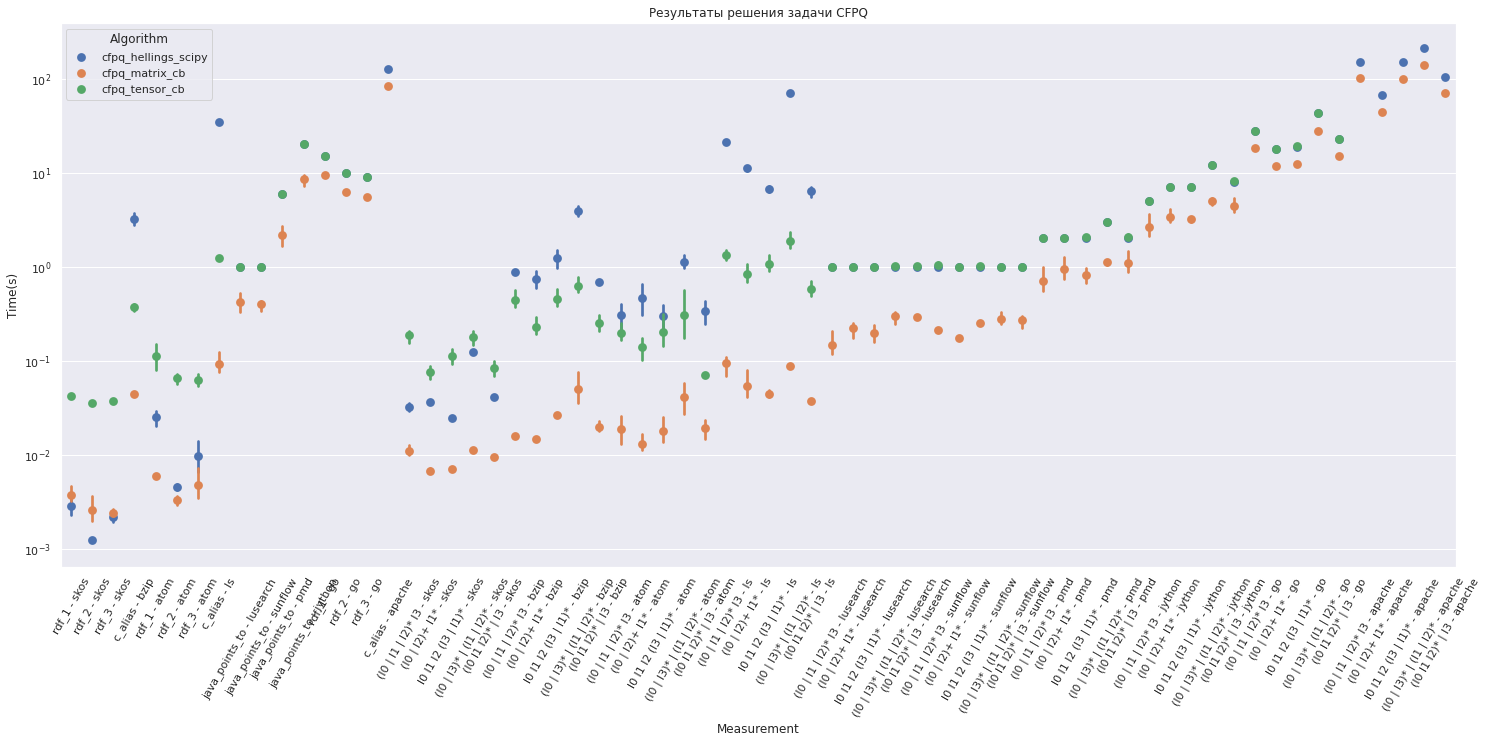

In [30]:
def plot_cfpq_results():
    res = pd.concat([create_df("cfpq", GRAPH_NAMES, CFPQ_ALGORITHMS), 
                     create_df("cfg", GRAPH_NAMES, CFPQ_ALGORITHMS)], ignore_index=True)
    res["Measurement"] = res["Query"] + " - " + res["Graph"]
    res.drop(columns=["Graph", "Query"])
    ax = plt.subplot(autoscale_on=True)
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time(s)",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Результаты решения задачи CFPQ")
    g.set_xticklabels(g.get_xticklabels(), rotation=60)


plot_cfpq_results()

### Результаты сравнения алгоритмов специализированного решения RPQ задачи и RPQ как CFPQ

Матричный алгоритм на всех комбинациях запросов и графов показывает себя на регулярных запросах лучше, чем специализированный алгоритм решения RPQ задачи. По сравнению с двумя другими КС-алгоритмами регулярный тензорный алгоритм показывает себя лучше и почти на всех графах быстрее, уступив только на самом маленьком графе (skos) алгоритму Хеллингса.

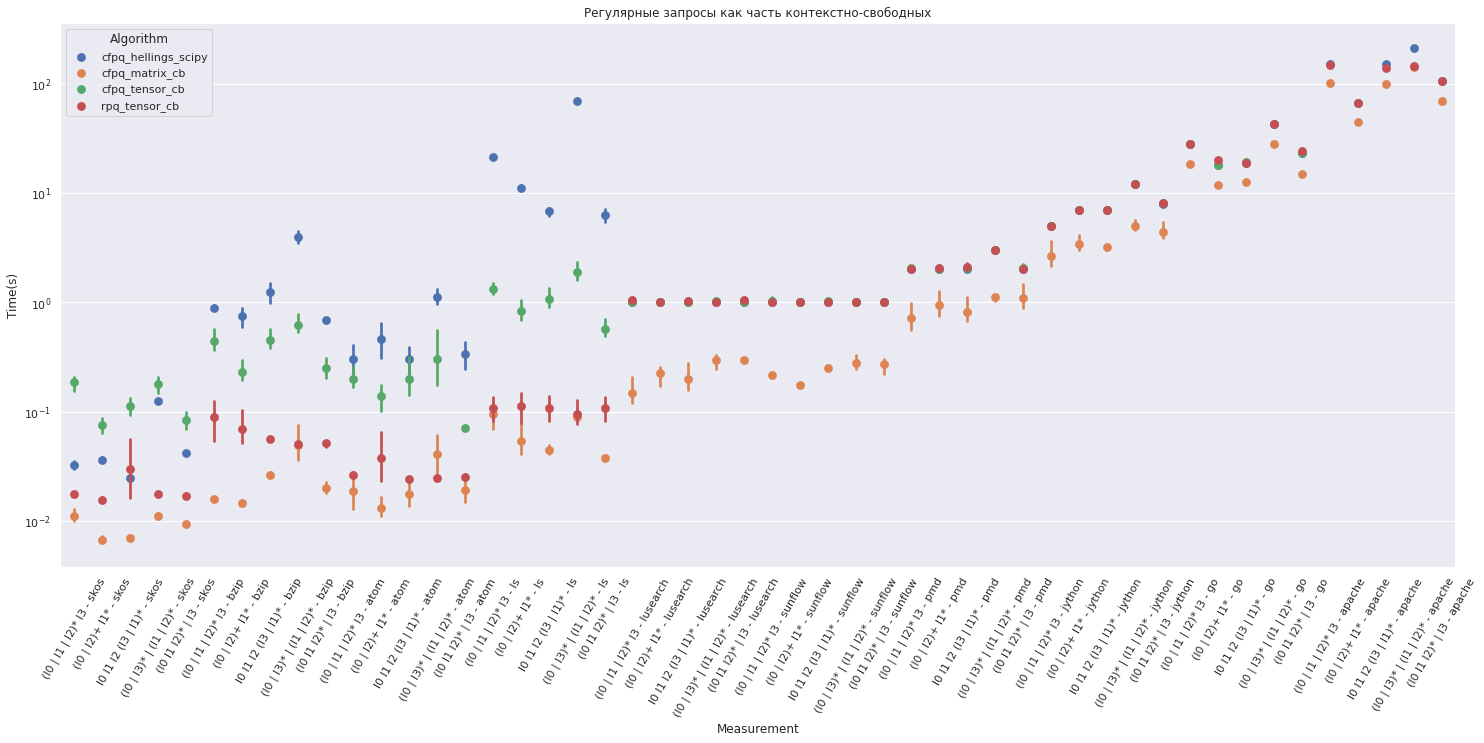

In [31]:
def plot_cfpq_results():
    res = pd.concat([create_df("cfg", GRAPH_NAMES, CFPQ_ALGORITHMS), 
                     create_df("rpq", GRAPH_NAMES, RPQ_ALGORITHMS)], ignore_index=True)
    res["Measurement"] = res["Query"] + " - " + res["Graph"]
    res.drop(columns=["Graph", "Query"])
    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time(s)",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Регулярные запросы как часть контекстно-свободных")
    g.set_xticklabels(g.get_xticklabels(), rotation=60)


plot_cfpq_results()

### Заключение

В ходе работы были получены следующие результаты относительно рассмотренных реализаций алгоритмов для решения задачи достижимости с контекстно-свободными ограничениями:

1. Наиболее эффективным по скорости работы является реализация матричного алгоритма. 
2. Применение специализированных алгоритмов для регулярных запросов не имеет смысла, так как реализация матричного алгоритма для контекстно-свободных запросов оказывается быстрее и охватывает более широкое множество возможных запросов.